# Part 1 - Data Exploration

## Problem Statement

"A picture is worth a thousand words".

This adage was first coined in the 1900s. The idea behind it was that complex and sometimes multiple ideas can be conveyed by a single still image. This suggests that perception is subjective and there are numerous interpretations to a single image.

In this capstone project, I will be exploring the use of Neural Networks to generate captions in English to best describe an image. 



## Contents

This project is split into several notebooks.

- Part 1: Data Exploration
- Part 2a: Feature Extraction (VGG16)
- Part 2b: Feature Extraction (Inception v3)
- Part 3a: Preprocessing and Modelling (VGG16 Base Model)
- Part 3b: Preprocessing and Modelling (VGG16 Base Model + Dropout)
- Part 3c: Preprocessing and Modelling (VGG16 Base Model + Dropout + Kernel Regularizer)
- Part 4a: Preprocessing and Modelling (Inception v3 Base Model)
- Part 4b: Preprocessing and Modelling (Inception v3 Base Model + Dropout)
- Part 4c: Preprocessing and Modelling (Inception v3 Base Model + Dropout + Kernel Regularizer)
- Part 5: Image Caption for Random Images Plus Audio Output

## Dataset

Data used in this modelling are:
* [`Images`]: Folder that contains 8091 photographs from Flickr
* [`Random_Images`]: Folder that contains 8 unseen images
* [`caption.txt`]: contains 40,455 captions that correspond to the photographs in the Images Folder. There are 5 captions to describe each photograph

## Mount Google Drive unto Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
# Check if in Colab Env
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [ ]:
# Change Mount Location
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive/'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Capstone/Code"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Colab: making sure  /content/drive//My Drive/Colab Notebooks/Capstone/Code  exists.

Colab: Changing directory to  /content/drive//My Drive/Colab Notebooks/Capstone/Code
/content/drive/My Drive/Colab Notebooks/Capstone/Code


In [ ]:
# check GPU assigned
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3232104945687760191
 xla_global_id: -1]

## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter 

# to explore text in captions data
import nltk
nltk.download('stopwords')
import regex as re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# to process the images
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# to process the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for modelling
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#utilities
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Set Directories of Google Drive

In [ ]:
# set directories
BASE_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k"
WORKING_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Code"

## Explore Captions Data

In [ ]:
# Load Captions Data into Pandas Dataframe for exploration
data = pd.read_csv(mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# Check for info and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [ ]:
# Check for shape
data.shape

(40455, 2)

In [ ]:
#Create functions to clean data
def clean(text):

    #lowercase all letters
    text = str(text.lower())
    
    #remove numerical values
    text = re.sub(" \d+", "", text)
    
    #remove 2 or less words
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    #remove non-ascii characters
    text = text.encode('ascii', errors = 'ignore').decode()
    
    #replace \n with space
    text = re.sub(r"(?<!\\)\\n|\n", " ", text)
    
    #remove punctuations
    text = re.sub("[^\w\s]", '', text)
    
    return text

In [ ]:
#use the function above to clean the captions
data['caption'] = data['caption'].map(lambda text: clean(text))
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...


## Tokenize

In [ ]:
#instantiate tokenizer
tokenizer = RegexpTokenizer(r'[a-z]+') 

In [ ]:
# "Run" Tokenizer
data['caption_token'] = data.apply(lambda row: tokenizer.tokenize(row['caption'].lower()), axis = 1)

In [ ]:
#check if tokenized
data.head()

,image,caption,caption_token
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...,"[child, pink, dress, climbing, set, stairs, en..."
1,1000268201_693b08cb0e.jpg,girl going into wooden building,"[girl, going, into, wooden, building]"
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,"[little, girl, climbing, into, wooden, playhouse]"
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse,"[little, girl, climbing, the, stairs, her, pla..."
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...,"[little, girl, pink, dress, going, into, woode..."


## Stop Words

In [ ]:
#remove general stopwords in the english language 
stop_words = stopwords.words('english')

#create new column for stopwords removed
data['clean_token'] = data['caption_token'].apply(lambda row: [word for word in row if word not in stop_words])

In [ ]:
#check dataframe
data.head()

,image,caption,caption_token,clean_token
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...,"[child, pink, dress, climbing, set, stairs, en...","[child, pink, dress, climbing, set, stairs, en..."
1,1000268201_693b08cb0e.jpg,girl going into wooden building,"[girl, going, into, wooden, building]","[girl, going, wooden, building]"
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,"[little, girl, climbing, into, wooden, playhouse]","[little, girl, climbing, wooden, playhouse]"
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse,"[little, girl, climbing, the, stairs, her, pla...","[little, girl, climbing, stairs, playhouse]"
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...,"[little, girl, pink, dress, going, into, woode...","[little, girl, pink, dress, going, wooden, cabin]"


In [ ]:
#create new columns for word counts of 'caption' column
data['caption_word_count'] = data['caption'].map(lambda text: len(text.split()))
data.head()

,image,caption,caption_token,clean_token,caption_word_count
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...,"[child, pink, dress, climbing, set, stairs, en...","[child, pink, dress, climbing, set, stairs, en...",8
1,1000268201_693b08cb0e.jpg,girl going into wooden building,"[girl, going, into, wooden, building]","[girl, going, wooden, building]",5
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,"[little, girl, climbing, into, wooden, playhouse]","[little, girl, climbing, wooden, playhouse]",6
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse,"[little, girl, climbing, the, stairs, her, pla...","[little, girl, climbing, stairs, playhouse]",7
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...,"[little, girl, pink, dress, going, into, woode...","[little, girl, pink, dress, going, wooden, cabin]",8


In [ ]:
#remove list from caption_token and clean_token
data['caption_token'] = data['caption_token'].apply(lambda row: ' '.join(row))
data['clean_token'] = data['clean_token'].apply(lambda row: ' '.join(row))
data.head()

,image,caption,caption_token,clean_token,caption_word_count
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...,child pink dress climbing set stairs entry way,child pink dress climbing set stairs entry way,8
1,1000268201_693b08cb0e.jpg,girl going into wooden building,girl going into wooden building,girl going wooden building,5
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,little girl climbing into wooden playhouse,little girl climbing wooden playhouse,6
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse,little girl climbing the stairs her playhouse,little girl climbing stairs playhouse,7
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...,little girl pink dress going into wooden cabin,little girl pink dress going wooden cabin,8


In [ ]:
#create new column for word counts of 'clean_token' column
data['clean_token_word_count'] = data['clean_token'].map(lambda text: len(text.split()))
data.head()

,image,caption,caption_token,clean_token,caption_word_count,clean_token_word_count
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs ...,child pink dress climbing set stairs entry way,child pink dress climbing set stairs entry way,8,8
1,1000268201_693b08cb0e.jpg,girl going into wooden building,girl going into wooden building,girl going wooden building,5,4
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse,little girl climbing into wooden playhouse,little girl climbing wooden playhouse,6,5
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs her playhouse,little girl climbing the stairs her playhouse,little girl climbing stairs playhouse,7,5
4,1000268201_693b08cb0e.jpg,little girl pink dress going into wooden c...,little girl pink dress going into wooden cabin,little girl pink dress going wooden cabin,8,7


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   image                   40455 non-null  object
 1   caption                 40455 non-null  object
 2   caption_token           40455 non-null  object
 3   clean_token             40455 non-null  object
 4   caption_word_count      40455 non-null  int64 
 5   clean_token_word_count  40455 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


## EDA on Captions Data

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
caption_word_count,40455.0,7.765443,2.824926,0.0,6.0,7.0,9.0,26.0
clean_token_word_count,40455.0,6.201508,2.070645,0.0,5.0,6.0,7.0,20.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


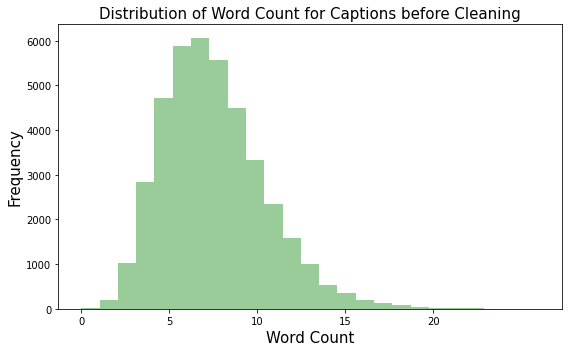

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.distplot(data['caption_word_count'], kde = False, color="green", bins = 25)
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Distribution of Word Count for Captions before Cleaning", fontsize=15)
plt.xticks(range(0, 25, 5))
plt.tight_layout()

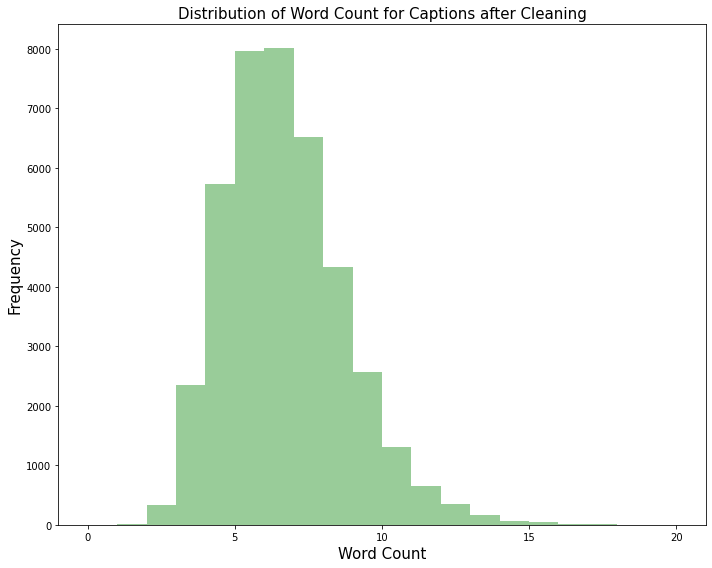

In [ ]:
plt.figure(figsize=(10, 8))
sns.distplot(data['clean_token_word_count'], kde = False, color="green", bins = 20)
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Distribution of Word Count for Captions after Cleaning", fontsize=15)
plt.xticks(range(0, 25, 5))
plt.tight_layout()

In [ ]:
#create dataframe of clean_token one list
words = []

words = ' '.join([i for i in data['clean_token']]).split()

In [ ]:
words[0:20]

['child',
 'pink',
 'dress',
 'climbing',
 'set',
 'stairs',
 'entry',
 'way',
 'girl',
 'going',
 'wooden',
 'building',
 'little',
 'girl',
 'climbing',
 'wooden',
 'playhouse',
 'little',
 'girl',
 'climbing']

In [ ]:
#N-gram 1 for words in caption
(pd.Series(nltk.ngrams(words, 1)).value_counts())[:10]

(dog,)        8136
(man,)        7265
(two,)        5637
(white,)      3940
(black,)      3832
(boy,)        3581
(woman,)      3402
(girl,)       3328
(wearing,)    3062
(people,)     2883
dtype: int64

In [ ]:
#N-gram 2 for words in caption
(pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

(white, dog)      1415
(brown, dog)      1375
(black, dog)      1203
(dog, running)     992
(two, dogs)        907
(little, girl)     713
(young, boy)       660
(black, white)     611
(two, people)      596
(man, wearing)     593
dtype: int64

In [ ]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:50]
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:50]

Text(0.5, 0, 'Number of Occurances')

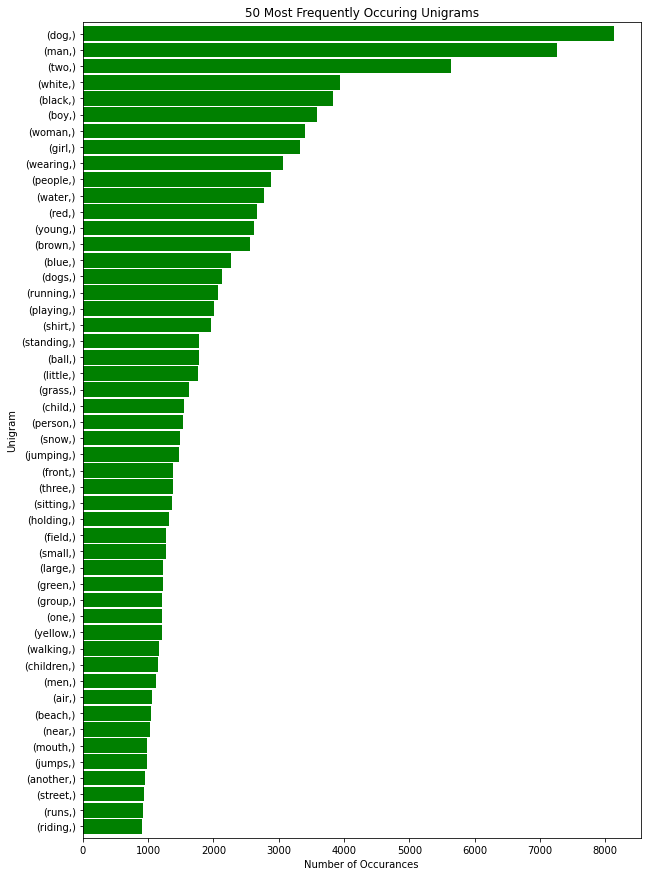

In [ ]:
unigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(10, 15))
plt.title('50 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('Number of Occurances')

Text(0.5, 0, 'Number of Occurances')

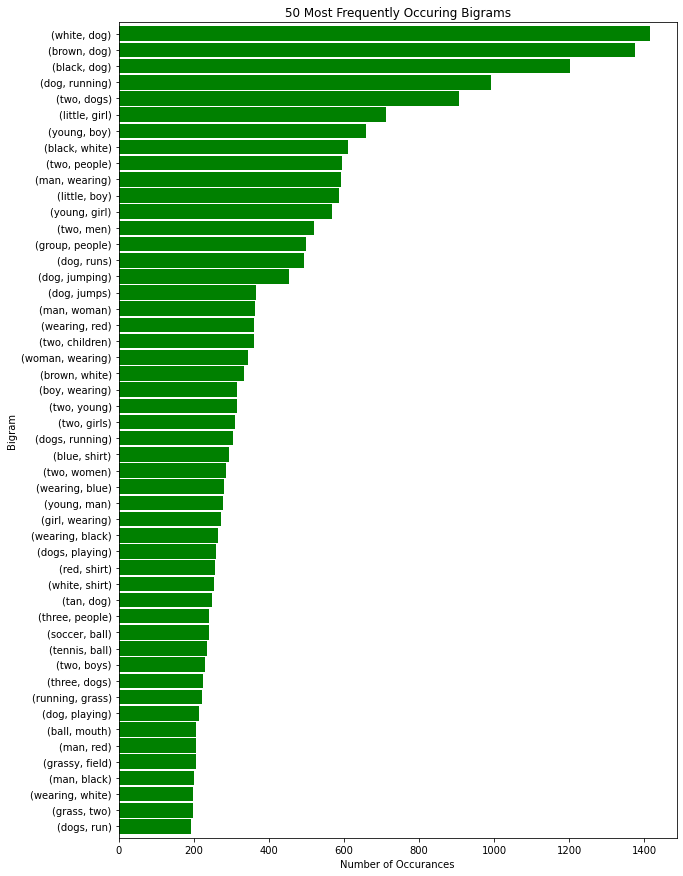

In [ ]:
bigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(10, 15))
plt.title('50 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

In [ ]:
# Load Captions Data into Pandas Dataframe for exploration
data2 = pd.read_csv(mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k/captions.txt")
data2.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


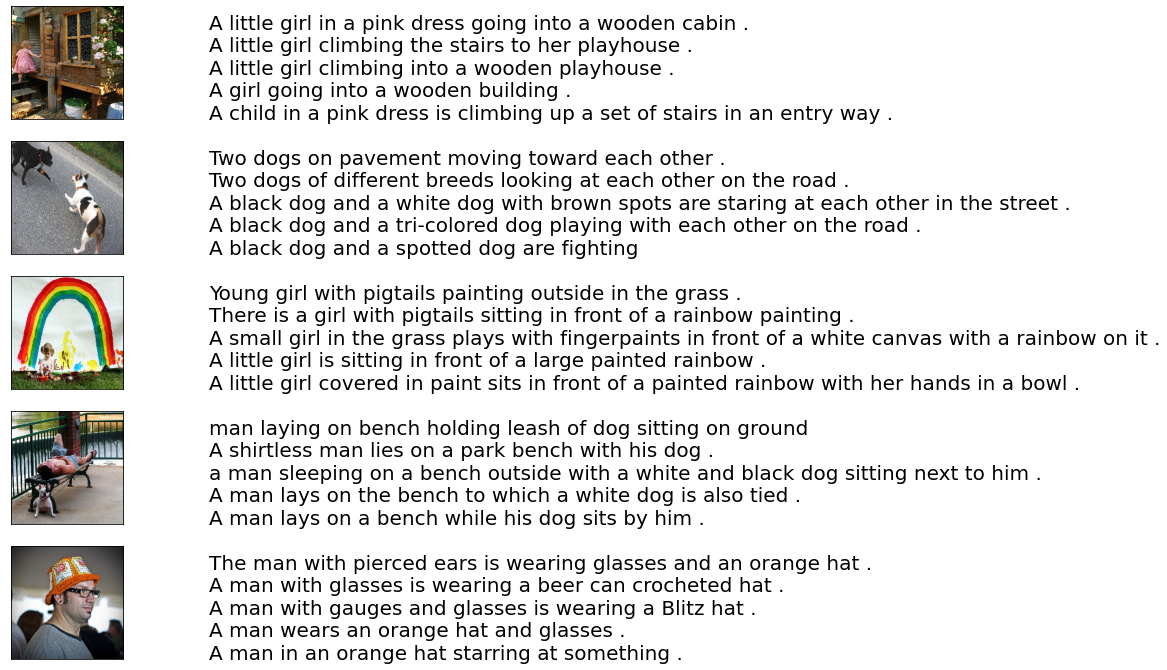

In [ ]:
dir_Flickr_jpg = mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k/Images"
uni_filenames = np.unique(data2.image.values)
len(uni_filenames)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(8,12))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data2["caption"].loc[data2["image"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()